Method: 

1. Apply PCA on independent variables to keep only high variance components 
2. Train a univariate model to predict PC1
3. Train a univariate model to predict PC2
4. Train a multivariate model to predict y1 and y2. This model takes predicted PC1 and PC2 values to make final predictions of y1 and y2.

In [2]:
# Load the required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
df = pd.read_pickle("/kaggle/input/dataset-elutions/complete_df.pkl")
df.shape

(157824, 10)

In [4]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [5]:
# Create a list of independent variables
X_vars = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

# Create a list of dependent variables
y_vars = ['y1', 'y2']

# Create training and testing data for the XGBoost model
X_train, y_train = train[X_vars], train[y_vars]
X_test, y_test = test[X_vars], test[y_vars]

In [6]:
# Store the index
X_train_index  = X_train.index
X_test_index  = X_test.index

In [7]:
# Set number of components to keep
pca = PCA(n_components=2)  
pca.fit(X_train)

# Transform training and test data using PCA
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

> I understand that there will be a leak due to this transform during cross validation, but for the sake of simplicity in this experiment, it is ignored.

In [8]:
pca.explained_variance_ratio_

array([0.88007929, 0.06626955])

In [9]:
# Create train df of PCs
X_train = pd.DataFrame(data = X_train)
X_train.columns = ['pc1', 'pc2']
X_train.index = X_train_index

In [10]:
# Create test df of PCs
X_test = pd.DataFrame(data = X_test)
X_test.columns = ['pc1', 'pc2']
X_test.index = X_test_index

In [11]:
# Define the parameters for the XGBoost model
xgb_params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',  # enable GPU acceleration
    'predictor': 'gpu_predictor',  # enable GPU acceleration for prediction
    #'n_gpus': 2  # use both GPUs
}

# Define the number of folds for cross-validation
n_folds = 5

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_folds)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(**xgb_params)

# Perform grid search to find the optimal hyperparameters
grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(xgb_model, grid, scoring='neg_mean_squared_error', 
                           n_jobs=-1, cv=tscv, verbose=1)

# Fit the grid search with a progress bar
for param_dict in tqdm(list(ParameterGrid(grid))):
    xgb_model.set_params(**param_dict)
    grid_search.fit(X_train, y_train)

# Train the XGBoost model using the optimal hyperparameters on full dataset
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 11%|█         | 1/9 [00:40<05:20, 40.10s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 22%|██▏       | 2/9 [01:07<03:47, 32.54s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 33%|███▎      | 3/9 [01:34<03:01, 30.28s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 44%|████▍     | 4/9 [02:02<02:26, 29.27s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 56%|█████▌    | 5/9 [02:30<01:54, 28.58s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 67%|██████▋   | 6/9 [02:57<01:24, 28.22s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 78%|███████▊  | 7/9 [03:24<00:55, 27.81s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 89%|████████▉ | 8/9 [03:52<00:27, 27.79s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


100%|██████████| 9/9 [04:19<00:00, 28.85s/it]


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
             reg_alpha=0, ...)

In [12]:
# Predict the y values for the test data
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error for the y values
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("MSE: %.2f" % mse)

MSE: 0.23


In [13]:
# Define the number of future time steps to forecast
n_steps = 14 * 24 * 12  # 14 days, 24 hours/day, 12 time steps/hour (5 minutes each)

# Create a copy of the last row of the training data to use as a starting point for the forecast
last_row = test.iloc[-1].copy()

# Create a dataframe to store the forecasted values
forecast_df = pd.DataFrame(index=pd.date_range(start=test.index[-1], periods=n_steps+1, freq='5T')[1:], columns=y_vars)

In [14]:
# Create a dataframe to store the forecasted values
forecast_df = pd.DataFrame(index=pd.date_range(start=test.index[-1], 
                                               periods=n_steps+1, freq='5T')[1:], 
                           columns=y_vars)


In [15]:
forecast_df.head()

,y1,y2
2017-07-02 00:00:00,NaN,NaN
2017-07-02 00:05:00,NaN,NaN
2017-07-02 00:10:00,NaN,NaN
2017-07-02 00:15:00,NaN,NaN
2017-07-02 00:20:00,NaN,NaN


## Create a model to predict next 14 days of PC1

In [16]:
# Define the XGBoost model
xgb_model_pc1 = xgb.XGBRegressor(**xgb_params)

# Perform grid search to find the optimal hyperparameters
grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Prepare the data for XGBoost
X_train_pc1, y_train_pc1 = X_train['pc1'].iloc[:-1], X_train['pc1'].iloc[1:]
X_test_pc1, y_test_pc1 = X_test['pc1'].iloc[:-1], X_test['pc1'].iloc[1:]

grid_search_pc1 = GridSearchCV(xgb_model_pc1, grid, scoring='neg_mean_squared_error', 
                           n_jobs=-1, cv=tscv, verbose=1)

# Fit the grid search with a progress bar
for param_dict in tqdm(list(ParameterGrid(grid))):
    xgb_model_pc1.set_params(**param_dict)
    grid_search_pc1.fit(X_train_pc1, y_train_pc1)

# Train the XGBoost model using the optimal hyperparameters on full dataset
xgb_model_pc1 = xgb.XGBRegressor(**xgb_params)
xgb_model_pc1.fit(X_train_pc1, y_train_pc1)

# Predict the y values for the test data
y_pred_pc1 = xgb_model_pc1.predict(X_test_pc1)

# Calculate the mean squared error for the y values
mse_pc1 = mean_squared_error(y_test_pc1, y_pred_pc1)

# Print the mean squared error
print("MSE: %.2f" % mse_pc1)

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 11%|█         | 1/9 [00:08<01:07,  8.50s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 22%|██▏       | 2/9 [00:17<01:00,  8.68s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 33%|███▎      | 3/9 [00:25<00:51,  8.52s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 44%|████▍     | 4/9 [00:33<00:42,  8.43s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 56%|█████▌    | 5/9 [00:42<00:33,  8.48s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 67%|██████▋   | 6/9 [00:51<00:25,  8.58s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 78%|███████▊  | 7/9 [00:59<00:16,  8.49s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 89%|████████▉ | 8/9 [01:08<00:08,  8.47s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


100%|██████████| 9/9 [01:16<00:00,  8.50s/it]

MSE: 0.01


In [17]:
# Predict PC1
# Define the number of future time steps to forecast
n_steps = 14 * 24 * 12  # 14 days, 24 hours/day, 12 time steps/hour (5 minutes each)

# Create a copy of the last row of the training data to use as a starting point for the forecast
last_row_pc1 = X_test_pc1.iloc[-1].copy()

# Create a dataframe to store the forecasted values
forecast_df_pc1 = pd.DataFrame(index=pd.date_range(start=X_test_pc1.index[-1], periods=n_steps+2, freq='5T')[1:])

# Predict the y values for the test data
y_pred_pc1 = xgb_model_pc1.predict(forecast_df_pc1.iloc[1:])

## Create a model to predict next 14 days of PC2

In [18]:
# Define the XGBoost model
xgb_model_pc2 = xgb.XGBRegressor(**xgb_params)

# Perform grid search to find the optimal hyperparameters
grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Prepare the data for XGBoost
X_train_pc2, y_train_pc2 = X_train['pc2'].iloc[:-1], X_train['pc2'].iloc[1:]
X_test_pc2, y_test_pc2 = X_test['pc2'].iloc[:-1], X_test['pc2'].iloc[1:]


grid_search_pc2 = GridSearchCV(xgb_model_pc2, grid, scoring='neg_mean_squared_error', 
                           n_jobs=-1, cv=tscv, verbose=1)

# Fit the grid search with a progress bar
for param_dict in tqdm(list(ParameterGrid(grid))):
    xgb_model_pc2.set_params(**param_dict)
    grid_search_pc2.fit(X_train_pc2, y_train_pc2)

# Train the XGBoost model using the optimal hyperparameters on full dataset
xgb_model_pc2 = xgb.XGBRegressor(**xgb_params)
xgb_model_pc2.fit(X_train_pc2, y_train_pc2)

# Predict the y values for the test data
y_pred_pc2 = xgb_model_pc2.predict(X_test_pc2)

# Calculate the mean squared error for the y values
mse_pc2 = mean_squared_error(y_test_pc2, y_pred_pc2)

# Print the mean squared error
print("MSE: %.4f" % mse_pc2)

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 11%|█         | 1/9 [00:08<01:06,  8.37s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 22%|██▏       | 2/9 [00:16<00:56,  8.06s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 33%|███▎      | 3/9 [00:24<00:48,  8.02s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 44%|████▍     | 4/9 [00:32<00:40,  8.11s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 56%|█████▌    | 5/9 [00:40<00:31,  7.95s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 67%|██████▋   | 6/9 [00:47<00:23,  7.86s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 78%|███████▊  | 7/9 [00:56<00:16,  8.02s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 89%|████████▉ | 8/9 [01:04<00:08,  8.06s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

MSE: 0.0226


In [19]:
# Predict PC2
# Define the number of future time steps to forecast
n_steps = 14 * 24 * 12  # 14 days, 24 hours/day, 12 time steps/hour (5 minutes each)

# Create a copy of the last row of the training data to use as a starting point for the forecast
last_row_pc2 = X_test_pc2.iloc[-1].copy()

# Create a dataframe to store the forecasted values
forecast_df_pc2 = pd.DataFrame(index=pd.date_range(start=X_test_pc2.index[-1], periods=n_steps+2, freq='5T')[1:])

# Predict the y values for the test data
y_pred_pc2 = xgb_model_pc2.predict(forecast_df_pc2[1:])

In [20]:
# Add PC1 and PC2 to forecast_df
forecast_df['pc1'] = y_pred_pc1
forecast_df['pc2'] = y_pred_pc2

### Forecast for 14 days (July 2, July 15)

In [21]:
y_pred = xgb_model.predict(forecast_df[['pc1','pc2']])

In [22]:
# Create dataframe of predicted y1 and y2
fourteen_days_pred = pd.DataFrame(y_pred)
fourteen_days_pred.columns = ['y1','y2']
fourteen_days_pred.index = forecast_df.index

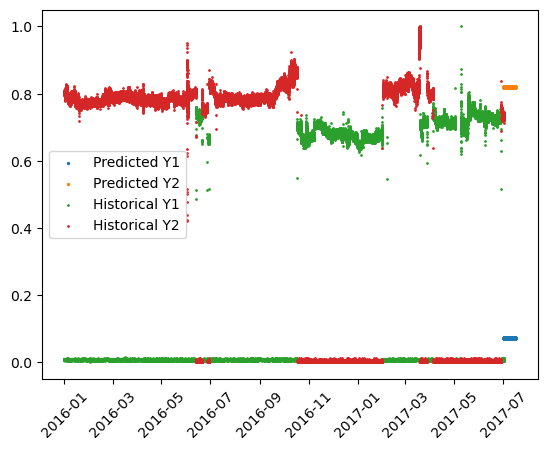

In [23]:
# plot the entire timeseries of y1 and y2
plt.scatter(fourteen_days_pred.index, fourteen_days_pred['y1'], s = 2)
plt.scatter(fourteen_days_pred.index, fourteen_days_pred['y2'], s = 2)
plt.scatter(df.index, df['y1'], s = 1)
plt.scatter(df.index, df['y2'], s = 1)
plt.legend(['Predicted Y1', 'Predicted Y2', 'Historical Y1', 'Historical Y2'])
#plt.scatter(fourteen_days_pred.index, fourteen_days_pred)
plt.xticks(rotation=45)
plt.show()